In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")


In [3]:
from finance.moex import index

ofz = await index.fetch_index()

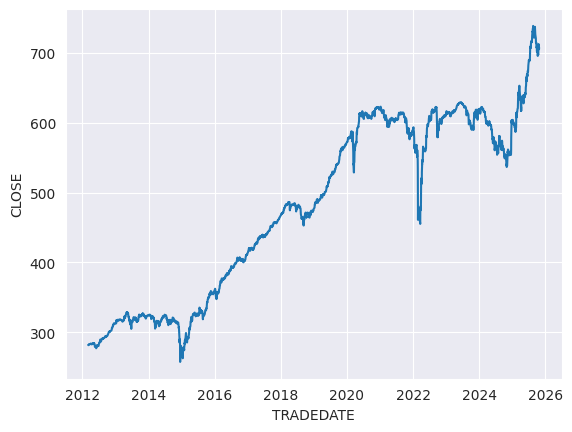

758


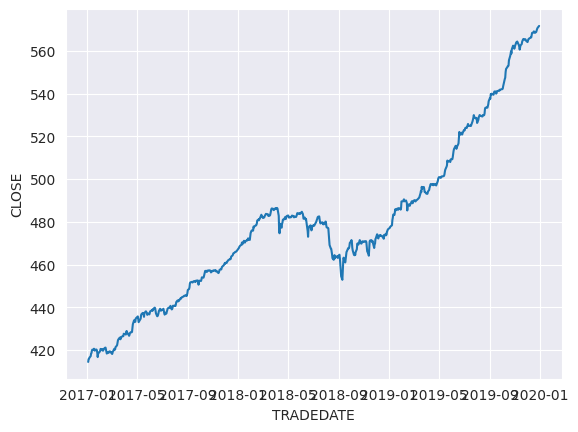

In [4]:
sns.lineplot(ofz, x=ofz.index, y="CLOSE")
plt.show()

start = pd.to_datetime("2017")
end = pd.to_datetime("2020")
idxs = (ofz.index > start) * (ofz.index < end)
data = ofz.loc[idxs]
print(len(data))

sns.lineplot(data, x=data.index, y="CLOSE")
plt.show()

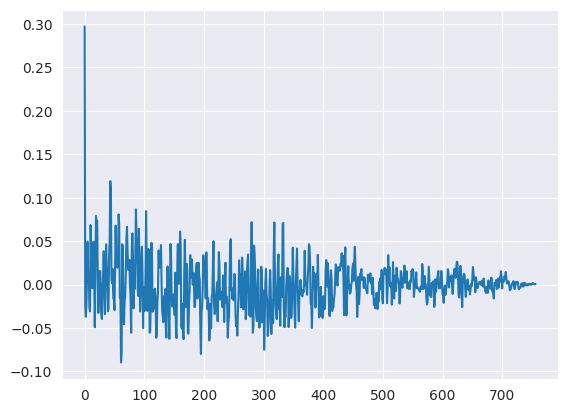

758
590
28
10
5


In [112]:
from statsmodels.tsa.stattools import acf, q_stat

ts = data["logret"].to_numpy()

corr = acf(ts, nlags=len(ts) - 1)
sns.lineplot(corr[1:])
plt.show()

print(len(ts))
_, _, pval = acf(ts, nlags=len(ts) - 1, qstat=True)
print((pval < 0.05).sum())
_, _, pval = acf(ts, qstat=True)
print((pval < 0.05).sum())
_, _, pval = acf(ts, nlags=10, qstat=True)
print((pval < 0.05).sum())
_, _, pval = acf(ts, nlags=5, qstat=True)
print((pval < 0.05).sum())

# Пропускаем первый элемент


# AR

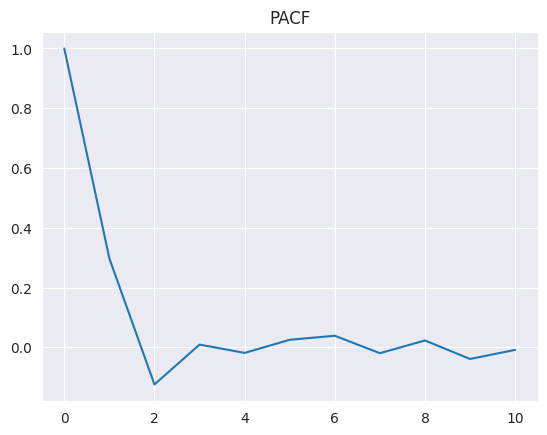

/home/raccoon/dev/ml/finance/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


$AIC: AR = 2,\quad MA = 0$

$BIC: AR = 2,\quad MA = 0$

In [163]:
from statsmodels.tsa.stattools import pacf, arma_order_select_ic

ofz_pacf = pacf(ts, nlags=10)
sns.lineplot(ofz_pacf)
plt.title("PACF")
plt.show()

res = arma_order_select_ic(ts, max_ar=12, max_ma=0, ic=["aic", "bic"], trend='n')
display(Markdown(f"$AIC: AR = {res["aic_min_order"][0]},\\quad MA = {res["aic_min_order"][1]}$"))
display(Markdown(f"$BIC: AR = {res["bic_min_order"][0]},\\quad MA = {res["bic_min_order"][1]}$"))

$E[r] = -8.319091828395075e-08$

$\sigma_r = 0.0020126839217031456$

$R^2_{adj} = 0.11079867774593055$

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  606
Model:                 ARIMA(2, 0, 0)   Log Likelihood                2902.329
Date:                Fri, 24 Oct 2025   AIC                          -5796.657
Time:                        23:51:39   BIC                          -5779.030
Sample:                             0   HQIC                         -5789.798
                                - 606                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      2.951      0.003       0.000       0.001
ar.L1          0.3472      0.025     13.877      0.000       0.298       0.396
ar.L2         -0.1385      0.026     -5.241      0.000      -0.190      -0.087
sigma2       4.05e-06   1.43e-07     28.343      0.000    3.77e-06    4.33e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               500.90
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(10, 2)


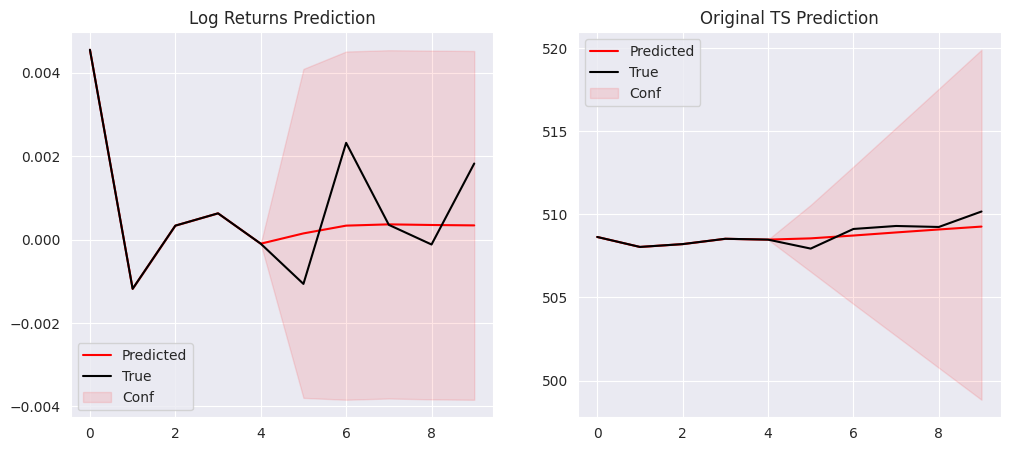

In [154]:
# import statsmodels as sm
import sklearn
import matplotlib.pyplot as plt
from IPython.display import Markdown
from statsmodels.graphics import tsaplots

n_back=5
n_forward = 5

ar_order = 2

train_point = int(len(ts) * 0.8)
ts_train, ts_test = ts[:train_point], ts[train_point:]

model = sm.tsa.arima.model.ARIMA(ts_train, order=(ar_order, 0, 0))
ofz_ar: sm.tsa.arima.model.ARIMAResults = model.fit()

resid_std = np.var(ofz_ar.resid[ar_order + 1:])
r_std = np.var(ts_train[ar_order+1:])


display(Markdown(f"$E[r] = {np.mean(ofz_ar.resid)}$"))
display(Markdown(f"$\\sigma_r = {np.std(ofz_ar.resid)}$"))
display(Markdown(f"$R^2_{{adj}} = {1 - resid_std / r_std}$"))
display(ofz_ar.summary())

forecast = ofz_ar.get_forecast(n_forward)
results = forecast.predicted_mean
conf = forecast.conf_int()

prev = ts_train[len(ts_train) - n_back:]

ts_orig = data["CLOSE"].to_numpy()[train_point - n_back:train_point + n_forward]

preds_orig = np.exp(np.concat((prev, results)))
preds_orig[0] = 1.0
preds_orig = np.cumprod(preds_orig) * ts_orig[0]

prevprev = np.hstack([prev.reshape(-1, 1), prev.reshape(-1, 1)])
conf = np.concat((prevprev, conf))
conf_orig = np.exp(conf)
conf_orig[0, :] = 1.0
conf_orig = np.cumprod(conf_orig, axis=0) * ts_orig[0]
print(conf_orig.shape)


def tsa_plt(ax, true, preds, conf, title):
    sns.lineplot(preds, label="Predicted", c="red", ax=ax)
    sns.lineplot(true, label="True", c="black", ax=ax)
    ax.fill_between(range(conf.shape[0]), conf[:, 0], conf[:, 1], color="red", alpha=0.1, label="Conf")
    ax.legend()
    ax.set_title(title)


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
tsa_plt(
    ax=axs[0], 
    true=ts[train_point - n_back : train_point + n_forward],
    preds=np.concat((prev, results)),
    conf=conf,
    title="Log Returns Prediction"
)
tsa_plt(
    ax=axs[1], 
    true=ts_orig,
    preds=preds_orig,
    conf=conf_orig,
    title="Original TS Prediction"
)
plt.show()


# MA